In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/Shared drives/DIP")

In [ ]:
# ALL IMPORTS
import numpy as np
from os import listdir
import cv2
from matplotlib.image import imread
from matplotlib import pyplot

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model, load_model
from keras.initializers import RandomNormal
from keras.optimizers import Adam

In [ ]:
# Load images from path
def load_images(path):
  sources = []
  targets = []
  for f in listdir(path):
    img = imread(path+f)
    src = img[:,:600]
    tar = img[:,600:]
    src = cv2.resize(src, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    tar = cv2.resize(tar, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
    sources.append(src)
    targets.append(tar)
  return [np.asarray(sources),np.asarray(targets)]

In [ ]:
# RUN WITH CAUTION
# Load images from train
# Rescaled 600*600*3 => 256*256*3
# Store matrices in dataready
path = "data/maps/train/"
[sources, targets] = load_images(path)
print("Images loaded")
filename = "dataready/trainingdata"
np.savez_compressed(filename,sources,targets)
print("Saved training")

Images loaded
Saved training


In [ ]:
# Displaying the rescaled images 
rescaled_data = np.load("dataready/trainingdata.npz")
sources = rescaled_data['arr_0']
targets = rescaled_data['arr_1']
print("Loaded rescaled images")
n = 3
for i in range(n):
  pyplot.subplot(2,n,1+i)
  pyplot.axis("off")
  pyplot.imshow(sources[i])
for i in range(n):
  pyplot.subplot(2,n,1+i+n)
  pyplot.axis("off")
  pyplot.imshow(targets[i])
pyplot.show()

In [ ]:
def load_data(filename):
  X = np.load(filename)
  sources = X['arr_0']
  targets = X['arr_1']
  sources = (sources-127.5)/127.5
  targets = (targets-127.5)/127.5
  return sources, targets

In [ ]:
X1, X2 = load_data("dataready/trainingdata.npz")
print("X1 shape: "+str(X1.shape))
print("X2 shape: "+str(X2.shape))


X1 shape: (1096, 256, 256, 3)
X2 shape: (1096, 256, 256, 3)


In [ ]:
class cGAN():

  def __init__(self):

    # Build and compile the discriminator
    self.img_shape = (256,256,3)
    self.filter_size = (4,4)
    self.stride = (2,2)
    self.unet = False
    self.optimizer = Adam(lr=0.0002,beta_1=0.5,beta_2=0.999)
    self.init_weights = RandomNormal(stddev=0.02)
    self.discriminator = self.Discriminator(self.img_shape,self.filter_size,self.stride)
    self.discriminator.compile(loss='binary_crossentropy',
                              optimizer=self.optimizer,
                              loss_weights=[0.5])
    
    # Build the generator
    self.generator = self.Generator(self.img_shape,self.filter_size,self.stride,self.unet)
    self.losses = []

    # Make model GAN
    z = Input(shape=self.img_shape)
    outputgen = self.generator(z)
    outputdes = self.discriminator([z,outputgen])
    self.discriminator.trainable = False
    self.gan = Model(z,[outputgen,outputdes])
    self.gan.compile(loss=['mae','binary_crossentropy'],
                  optimizer=self.optimizer,
                  loss_weights=[100,1])
  
  def Discriminator(self,input_shape, kernel_size,stride):
    src_input = Input(shape=input_shape)
    tar_input = Input(shape=input_shape)
  
    input = Concatenate()([src_input,tar_input])

    output = Conv2D(64,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(input)
    output = LeakyReLU(alpha=0.2)(output)

    output = Conv2D(128,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(output)
    output = BatchNormalization()(output)
    output = LeakyReLU(alpha=0.2)(output)
    
    output = Conv2D(256,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(output)
    output = BatchNormalization()(output)
    output = LeakyReLU(alpha=0.2)(output)
    
    output = Conv2D(512,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(output)
    output = BatchNormalization()(output)
    output = LeakyReLU(alpha=0.2)(output)
    
    output = Conv2D(512,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(output)
    output = BatchNormalization()(output)
    output = LeakyReLU(alpha=0.2)(output)

    output = Conv2D(1,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(output)
    output = Activation('sigmoid')(output)
    
    model = Model([src_input,tar_input],output)
    model.summary()
    return model

  # Encoder Unit      : Convolution-BatchNorm-ReLU
  def encoderUnit(self,prevLayer, n_filter, s_filter, stride,bnorm=False):
    init = RandomNormal(stddev=0.02)
    output = Conv2D(n_filter,s_filter,
                    strides = stride,
                    padding='same',
                    kernel_initializer = self.init_weights)(prevLayer)
    if bnorm:
      output = BatchNormalization()(output)
    output = LeakyReLU(alpha=0.2)(output)
    return output
  
  # Decoder Unit      : Convolution-BatchNorm-Dropout-ReLU
  def decoderUnit(self,prevLayer, skipLayer, n_filter, s_filter, stride, dropout_rate):
    init = RandomNormal(stddev=0.02)
    output = Conv2DTranspose(n_filter,s_filter,
                            strides=stride,
                            padding='same',
                            kernel_initializer=self.init_weights)(prevLayer)
    output = BatchNormalization()(output,training=True)
    if dropout_rate != 0:
      output = Dropout(rate=dropout_rate)(output)
    if skipLayer!=None:
      output = Concatenate()([output,skipLayer])
    output = Activation('relu')(output)
    return output


  def Generator(self,input_shape, kernel_size,stride, unet=False):
    input = Input(shape=input_shape)
    init = RandomNormal(stddev=0.02)
    encoder1 = self.encoderUnit(input,64,kernel_size,stride=stride,bnorm=False)
    encoder2 = self.encoderUnit(encoder1,128,kernel_size,stride=stride,bnorm=True)
    encoder3 = self.encoderUnit(encoder2,256,kernel_size,stride=stride,bnorm=True)
    encoder4 = self.encoderUnit(encoder3,512,kernel_size,stride=stride,bnorm=True)
    encoder5 = self.encoderUnit(encoder4,512,kernel_size,stride=stride,bnorm=True)
    encoder6 = self.encoderUnit(encoder5,512,kernel_size,stride=stride,bnorm=True)
    encoder7 = self.encoderUnit(encoder6,512,kernel_size,stride=stride,bnorm=True)

    base = Conv2D(512,
                  kernel_size=kernel_size,
                  strides=stride,
                  padding='same',
                  kernel_initializer=self.init_weights)(encoder7)
    base = Activation('relu')(base)

    if unet:
      decoder7 = self.decoderUnit(base,encoder7,512,kernel_size,stride=stride,dropout_rate=0.5)
      decoder6 = self.decoderUnit(decoder7,encoder6,512,kernel_size,stride=stride,dropout_rate=0.5)
      decoder5 = self.decoderUnit(decoder6,encoder5,512,kernel_size,stride=stride,dropout_rate=0.5)
      decoder4 = self.decoderUnit(decoder5,encoder4,512,kernel_size,stride=stride,dropout_rate=0.0)
      decoder3 = self.decoderUnit(decoder4,encoder3,256,kernel_size,stride=stride,dropout_rate=0.0)
      decoder2 = self.decoderUnit(decoder3,encoder2,128,kernel_size,stride=stride,dropout_rate=0.0)
      decoder1 = self.decoderUnit(decoder2,encoder1,64,kernel_size,stride=stride,dropout_rate=0.0)
    else:
      decoder7 = self.decoderUnit(base,None,512,kernel_size,stride=stride,dropout_rate=0.5)
      decoder6 = self.decoderUnit(decoder7,None,512,kernel_size,stride=stride,dropout_rate=0.5)
      decoder5 = self.decoderUnit(decoder6,None,512,kernel_size,stride=stride,dropout_rate=0.5)
      decoder4 = self.decoderUnit(decoder5,None,512,kernel_size,stride=stride,dropout_rate=0.0)
      decoder3 = self.decoderUnit(decoder4,None,256,kernel_size,stride=stride,dropout_rate=0.0)
      decoder2 = self.decoderUnit(decoder3,None,128,kernel_size,stride=stride,dropout_rate=0.0)
      decoder1 = self.decoderUnit(decoder2,None,64,kernel_size,stride=stride,dropout_rate=0.0)

    output = Conv2DTranspose(3,kernel_size=kernel_size,
                    strides=stride,
                    padding='same',
                    kernel_initializer=self.init_weights)(decoder1)
    output = Activation('tanh')(output)
    model = Model(input,output)
    model.summary()
    return model

  # Train our entire model
  def train(self,source,target,epochs=100,n_batch=1):
    patch_size = self.discriminator.output_shape[1]
    yreal = np.ones((n_batch,patch_size,patch_size))
    yfake = np.zeros((n_batch,patch_size,patch_size))
    bat_per_epo = int(len(source) / n_batch)
    n_steps = bat_per_epo * epochs
    loss = np.array([0.0,0.0,0.0])

    for epoch in range(n_steps):
      if (epoch)%(bat_per_epo) == 0:
        print("======="+str(epoch//bat_per_epo)+"/"+str(epochs)+"=======")
      
      idx = np.random.randint(0, source.shape[0], n_batch)
      X1 = source[idx]
      X2 = target[idx]

      X1fake = self.generator.predict(X1)
      dis_loss_real = self.discriminator.train_on_batch([X1,X2],yreal)
      dis_loss_fake = self.discriminator.train_on_batch([X1,X1fake],yfake)

      gen_loss,_,_ = self.gan.train_on_batch(X1,[X2,yreal])
      loss += np.array([dis_loss_real,dis_loss_fake,gen_loss])

      if (epoch)%(bat_per_epo) == bat_per_epo-1:
        self.evaluate(epoch)
        loss = loss/bat_per_epo
        self.losses.append(loss)
        print("disloss_real: "+str(loss[0])+",dislossfake: "+str(loss[1])+"genloss: "+str(loss[2]))
        loss = np.array([0.0,0.0,0.0])
        print("=======completed=======")
      
      if (epoch)%(bat_per_epo*10)==0 and epoch!=0:
        self.savemodel(epoch//(bat_per_epo*10))
      if epoch == n_steps-1:
        self.savemodel(epochs//10)

  def savemodel(self,x):
    self.discriminator.save("./models/"+str(x)+"dis.h5")
    self.generator.save("./models/"+str(x)+"gen.h5")
    self.gan.save("./models/"+str(x)+"gan.h5")
  
  def loadmodel(self,dir,i):
    self.discriminator = load_model("./"+dir+"/"+str(i)+"dis.h5")
    self.generator = load_model("./"+dir+"/"+str(i)+"gen.h5")
    self.gan = load_model("./"+dir+"/"+str(i)+"gan.h5")

  def getresult(self,X):
    Y = self.generator.predict(X)
    return Y

  def evaluate(self,iter):
    idx = np.random.randint(0, X1.shape[0], 3)
    Y = self.generator.predict(X1[idx])
    for i in range(3):
      pyplot.subplot(3,3,1+i)
      pyplot.axis("off")
      pyplot.imshow((X1[idx[i]]+1)/2)
    for i in range(3):
      pyplot.subplot(3,3,1+i+3)
      pyplot.axis("off")
      pyplot.imshow((Y[i]+1)/2)
    for i in range(3):
      pyplot.subplot(3,3,1+i+6)
      pyplot.axis("off")
      pyplot.imshow((X2[idx[i]]+1)/2)
    pyplot.savefig("./figures/"+str((iter+1)//X1.shape[0]))


  

In [ ]:
mymodel = cGAN()

In [ ]:
mymodel.train(X1,X2,100,1)

=======0/100=======
disloss_real: 0.10107293899210183,dislossfake: 0.08130953734465297genloss: 14.400573191851596
=======completed=======
=======1/100=======


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:212: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:216: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

disloss_real: 0.03937590724797993,dislossfake: 0.03316125313487951genloss: 13.320636505954457
=======completed=======
=======2/100=======
disloss_real: 0.031095883092642405,dislossfake: 0.012966182962791076genloss: 13.173931592681113
=======completed=======
=======3/100=======
disloss_real: 0.002852698109143065,dislossfake: 0.009872017844062393genloss: 12.980951899812169
=======completed=======
=======4/100=======
disloss_real: 0.024275251394333505,dislossfake: 0.020752060944355468genloss: 13.241217843807526
=======completed=======
=======5/100=======
disloss_real: 0.01986556122959153,dislossfake: 0.015036779615070207genloss: 12.860565478893092
=======completed=======
=======6/100=======
disloss_real: 0.006724421365287751,dislossfake: 0.005688689165019878genloss: 12.84399803037191
=======completed=======
=======7/100=======
disloss_real: 0.016139761143176515,dislossfake: 0.00797127105153883genloss: 12.316762330105705
=======completed=======
=======8/100=======
disloss_real: 0.030408995

In [ ]:
prevmodel_encoder_decoder = cGAN()

In [ ]:
prevmodel_unet = cGAN()

In [ ]:
prevmodel_unet_2 = cGAN()

In [ ]:
prevmodel_unet_2.loadmodel("../MDIP/models_aerial_to_maps",10)

In [ ]:
prevmodel_unet.loadmodel("models_maps_to_aerial",9)

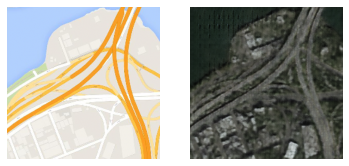

In [ ]:
Y=prevmodel_unet.generator.predict(X2[7:8])
pyplot.subplot(1,2,2)
pyplot.axis("off")
pyplot.imshow((Y[0]+1)/2)
pyplot.subplot(1,2,1)
pyplot.axis("off")
pyplot.imshow((X2[7]+1)/2)
pyplot.show()

In [ ]:
prevmodel_encoder_decoder.loadmodel("encoder_decoder_models",5)

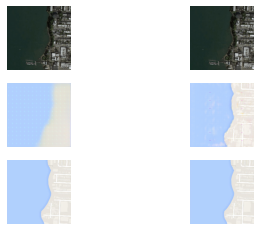

In [ ]:
n=0
Y = prevmodel_encoder_decoder.generator.predict(X1[n:n+1])
Y2 = prevmodel_unet_2.generator.predict(X1[n:n+1])
#pyplot.imshow((Y[0]+1)/2)

pyplot.subplot(3,2,1)
pyplot.axis("off")
pyplot.imshow((X1[n]+1)/2)
pyplot.subplot(3,2,3)
pyplot.axis("off")
pyplot.imshow((Y[0]+1)/2)
pyplot.subplot(3,2,5)
pyplot.axis("off")
pyplot.imshow((X2[n]+1)/2)
pyplot.subplot(3,2,2)
pyplot.axis("off")
pyplot.imshow((X1[n]+1)/2)
pyplot.subplot(3,2,4)
pyplot.axis("off")
pyplot.imshow((Y2[0]+1)/2)
pyplot.subplot(3,2,6)
pyplot.axis("off")
pyplot.imshow((X2[n]+1)/2)
pyplot.savefig("./encoder_unet/"+str(50))